In [1]:
%pip install -q pdfplumber PyPDF2 pypdfium2

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pdfplumber
import PyPDF2
import pypdfium2
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt

# Function declaration

In [2]:
def get_header_footer_pos(image_array: np.ndarray, threshold: int = 127):
    """
    Crop header and footer from a grayscale image based on a pixel intensity threshold.

    Args:
        image_array (numpy.ndarray): Input image as a 2D array.
        threshold (int): Pixel intensity threshold to identify content.
    Returns:
        numpy.ndarray: Cropped image array.
    """
    height, _ = image_array.shape
    row_text_counts = np.sum(image_array < threshold, axis=1)
    has_text_signal = row_text_counts > 0
    
    # top crop (header)
    top_crop_row = 0
    reach_header = False
    for i in range(int(height * 0.15)):
        if has_text_signal[i]:
            reach_header = True
        if reach_header and not has_text_signal[i]:
            top_crop_row = i
            break
    
    # bottom crop (footer)
    bottom_crop_row = height
    reach_footer = False
    for i in range(height - 1, int(height * 0.85), -1):
        if has_text_signal[i]:
            reach_footer = True
        if reach_footer and not has_text_signal[i]:
            bottom_crop_row = i
            break
    
    return top_crop_row, bottom_crop_row

# Crop Image

# OCR

Range: page **6 - 256**

In [3]:
page_range = list(range(6, 256))
results = []

### Run

In [4]:
# path declarations
input_pdf = "../data/raw/Duoc-Dien-Viet-Nam-V-tap-2.pdf"
output_csv = "../data/raw/raw_text_extract.csv"
output_txt = "../data/raw/raw_texts.txt"

In [5]:
with pdfplumber.open(input_pdf) as pdf_document:
    results = []

    for page_id in page_range:
        page = pdf_document.pages[page_id-1]
        
        # Render at high DPI for better header/footer detection
        dpi = 400
        p_image = page.to_image(resolution=dpi)
        image = p_image.original
        pix_width, pix_height = image.size
        image_array = np.array(image.convert("L"))  # Convert to grayscale
        
        # Get crop positions in pixel coordinates
        top_crop_px, bottom_crop_px = get_header_footer_pos(image_array)
        
        # Get page dimensions from bbox
        p_x0, p_top, p_x1, p_bottom = page.bbox
        
        # Convert pixel coordinates to PDF points
        points_per_pixel = page.height / pix_height
        
        # Calculate absolute crop coordinates relative to page top
        top_crop_pt = p_top + (top_crop_px * points_per_pixel)
        bottom_crop_pt = p_top + (bottom_crop_px * points_per_pixel)
        
        # Ensure crop box is within page bounds
        top_crop_pt = max(p_top, min(top_crop_pt, p_bottom))
        bottom_crop_pt = max(p_top, min(bottom_crop_pt, p_bottom))
        
        # Extraction settings
        x_tolerance = 5
        y_tolerance = 5
        
        # Ensure top < bottom
        if top_crop_pt >= bottom_crop_pt:
            print(f"Warning: Invalid crop on page {page_id}, skipping crop")
            text = page.extract_text(x_tolerance=x_tolerance, y_tolerance=y_tolerance)
        else:
            # Create crop bounding box (x0, top, x1, bottom)
            bbox = (p_x0, top_crop_pt, p_x1, bottom_crop_pt)
            
            # Apply crop and extract text
            cropped_page = page.crop(bbox)
            text = cropped_page.extract_text(x_tolerance=x_tolerance, y_tolerance=y_tolerance)
        
        if text:
            results.append((page_id, text.strip()))
        else:
            print("No text detected on page", page_id)
            results.append((page_id, ""))

### Process the result

In [6]:
df = pd.DataFrame(results, columns=["page_id", "text"])
df = df.sort_values(by='page_id').reset_index(drop=True)
df.to_csv(output_csv, index=False, encoding='utf-8')

In [7]:
df.head()

,page_id,text
0,6,Dược ĐIÊN VIỆT NAM V\nQUI ĐỊNH CHUNG\n1. Tên c...
1,7,Mát: 10 °c đến 20 °c.\nNhiệt độ phòng: 20 °c đ...
2,8,DƯỢC ĐIÊN VIỆT NAM V\n17. Trong chuyên luận kh...
3,9,DƯỢC ĐIỀN VIỆT NAM V\n27. Hỗn hợp của các chất...
4,10,39. Dược liệu dùng sàn xuất thuốc thành phẩm (...


## EDA

count     250.000000
mean     4327.668000
std       630.927555
min        29.000000
25%      4110.250000
50%      4354.000000
75%      4644.500000
max      5640.000000
Name: text, dtype: float64


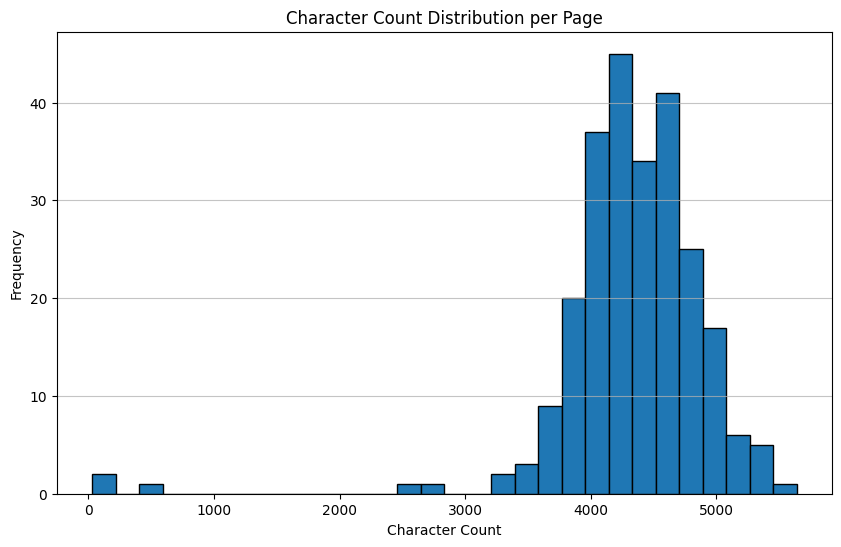

In [8]:
try:
    df.shape
except Exception:
    print("Loading data from CSV...")
    df = pd.read_csv(output_csv, encoding='utf-8')
    df.shape
    
character_count = df['text'].str.len()
print(character_count.describe())
plt.figure(figsize=(10, 6))
plt.hist(character_count, bins=30, edgecolor='black')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Character Count Distribution per Page')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [9]:

low_char_pages = df[character_count < 500]
print(f"Pages with character count < 500: {len(low_char_pages)}")
print("\nFirst 10 pages with character count < 500:")
print(low_char_pages.head(10))

Pages with character count < 500: 2

First 10 pages with character count < 500:
    page_id                                               text
6        12  Các chuyên luận\nHƯYÉT THANH, SINH PHẨM\nVÀ VẮ...
78       84                    Các chuyên luận\nDươc LIÊU\n• •


In [10]:
import re
delimeters = r'.?!\n'

all_text = " ".join(df['text'].tolist())

sentences = re.split(f'[{delimeters}]', all_text)
sentences = [s.strip() for s in sentences if s.strip() and len(s.strip()) > 20]
sentence_count = len(sentences)
print(f"Total number of sentences: {sentence_count}")

print("First 10 sentences:")
for i, sentence in enumerate(sentences[:20]):
    print(f"{i+1}. {sentence}")

Total number of sentences: 17862
First 10 sentences:
1. Tên chính cùa các chuyên luận là tcn Việt Nam, sau tên Việt Nam là tên Latin và những tên Việt Nam thông dụng
2. Đối với dược liệu: Có thể dùng tên qui ước cùa dược liệu hoặc dùng tên cây, con kèm theo bộ phận dùng lảm thuốc đê
3. làm tên chuyên luận, những từ chỉ bộ phận dùng lảm thuốc để trong dấu ngoặc đơn, ví dụ: (Lá), (Quả), (Thân rễ)
4. qui ước của dược liệu là tên của vị thuốc đã được dùng trong y học cổ truyền, ví dụ: Phù bình, Bạch giới tử
5. Mỗi chuyên luận cùa Dược điển Việt Nam V (chuyên luận riêng hay phụ lục) là một tiêu chuẩn về chât lượng thuôc hoặc
6. phương pháp kiểm nghiệm thuốc của Việt Nam
7. Nguyên từ lượng các nguyên tố trong Dược điển Việt Nam V là các giá trị đã được thừa nhận ghi ữong Phụ lục
8. Bảng nguyên tử lượng các nguyên tổ
9. Các đơn vị đo lường dùng trong Dược điển Việt Nam V đều tuân theo Luật Đo lường ban hành ngày 11/11/2011 và
10. Nghị định của Chính phủ sổ 86/2012/NĐ-CP ngày 19/10/2012 quy đị

In [13]:
with open(output_txt, "w", encoding='utf-8') as f:
    f.write(all_text)
    print("Saved to", output_txt)

Saved to ../data/raw/raw_texts.txt
